# Linear Mixed Models

Build some linear mixed models about our data

## Import data

In [1]:
import os
import sys
from socket import gethostname

hostname = gethostname()

import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns
import json
import random

from itertools import cycle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error

from scipy.stats import linregress

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor


# there is a FutureWarning in sklearn StandardScalar which is really annoying. This ignores it.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

try:
  import google.colab
  IN_COLAB = True
  !pip install adjustText
  from google.colab import drive
  drive.mount('/content/drive')
  datadir = '/content/drive/MyDrive/Projects/CF/Adelaide/CF_Data_Analysis'
except ImportError:
  IN_COLAB = False
  datadir = '..'


if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False

import cf_analysis_lib


## Read the data frames

In [2]:
sequence_type = "MGI"
datadir = '..'
#sslevel = 'level2_norm_ss.tsv.gz'
sslevel = 'subsystems_norm_ss.tsv.gz'
ss_df = cf_analysis_lib.read_subsystems(os.path.join(datadir, sequence_type, "FunctionalAnalysis", "subsystems", sslevel), sequence_type)
ss_df = ss_df.T
print(f"The subsystems df has shape: {ss_df.shape}")

taxa = "family"
genus_otu = cf_analysis_lib.read_taxonomy(datadir, sequence_type, taxa)
genus_otu = genus_otu.T
print(f"The taxonomy df has shape: {genus_otu.shape}")
metadata = cf_analysis_lib.read_metadata(datadir, sequence_type, categorise=True)
print(f"The metadata df has shape: {metadata.shape}")

df = ss_df.merge(genus_otu, left_index=True, right_index=True, how='inner')

The subsystems df has shape: (127, 769)
The taxonomy df has shape: (127, 743)
The metadata df has shape: (127, 166)


## Rename the columns

Statsmodels can't handle column names with spaces or special characters, and so we rename them

In [3]:
df.columns = [re.sub(r'\W+', '_', col) for col in df.columns]
metadata.columns = [re.sub(r'\W+', '_', col) for col in metadata.columns]

In [4]:
df.head(3)

,2_3_diacetamido_2_3_dideoxy_d_mannuronic_acid,2_O_alpha_mannosyl_D_glycerate_utilization,2_aminophenol_Metabolism,2_ketoacid_oxidoreductases_disambiguation,2_oxoglutarate_dehydrogenase_,2_phosphoglycolate_salvage,3_amino_5_hydroxybenzoic_Acid_Synthesis,4_hydroxybenzoyl_CoA_reductase,5_methylaminomethyl_2_thiouridine,A_Hypothetical_Protein_Related_to_Proline_Metabolism,...,Pelagicoccaceae,Puniceicoccaceae,Chthoniobacteraceae,Terrimicrobiaceae,Limisphaeraceae,Akkermansiaceae,Rubritaleaceae,Verrucomicrobia_subdivision_6,Verrucomicrobiaceae,Eremiobacteraceae
1068841_20180306_S,10.085904,2784.895948,516.160945,231.778018,122.573392,342.327431,783.041862,0.0,4136.703664,827.439614,...,0.000000,0.808564,0.0,0.0,0.0,22.370261,0.808564,0.0,3.234255,0.0
1447437_20171212_S,59.260325,1065.438272,543.947408,554.136026,428.171446,301.915763,679.310468,0.0,3913.676651,732.956657,...,1.271183,0.635592,0.0,0.0,0.0,36.864321,0.000000,0.0,3.177959,0.0
1128691_20171206_S,0.000000,426.619709,912.767750,49.606943,213.640568,277.798880,423.312580,0.0,2093.412992,236.459761,...,0.000000,10.749798,0.0,0.0,0.0,14.333065,0.000000,0.0,10.749798,0.0


#### Remove the columns that start with numbers

The lmm breaks on these!

In [5]:
nos = {"1": "one", "2": "two", "3": "three", "4": "four", "5": "five", "6": "six", "7" : "seven", "8": "eight", "9" : "nine"}
new_df_cols = {}
for c in df.columns:
    if c[0] in nos:
        new_df_cols[c] = c.replace(c[0], nos[c[0]], 1)
df = df.rename(columns=new_df_cols)

newmetacols = {}
for c in metadata.columns:
    if c[0] in nos:
        newmetacols[c] = c.replace(c[0], nos[c[0]], 1)
metadata = metadata.rename(columns=newmetacols)
    

## Convert categories and objects to numeric forms

We use numbers if we have them, we keep the MGI/MinION ID so we can use it to join tables, but we don't want to use it as a predictor.

We convert categories to their codes so we get numbers. 

We drop the other columns so we don't try and predict on free text columns.

I'm not sure what to do about dates, yet, so I ignore them for now

In [6]:
# we make a copy of each data frame and then overwrite the columns. Internally this is more efficient than making a df one
# column at a time.
encoded_metadata = metadata.copy()
to_delete = ['Pseudomonas_Culture'] # this is a duplicate columns with 'CS_Pseudomonas_aeruginosa'
for col in metadata:
    if pd.api.types.is_numeric_dtype(metadata[col]):
        continue
    elif col == sequence_type:
        continue
    elif metadata[col].dtypes == 'category':
        encoded_metadata[col] = metadata[col].cat.codes
    else:
        print(f'Dropping {col}: {metadata[col].dtypes}')
        to_delete.append(col)

encoded_metadata = encoded_metadata.drop(columns=to_delete)


Dropping minion: object
Dropping Sample_date: datetime64[ns]
Dropping Room: object
Dropping Culture_Result_Matched_with_sequenced_sample_: object
Dropping Cutured_in_previous_12_months: object
Dropping Others_cultured: object
Dropping Spec_IgG: object
Dropping CF_gene_2: object
Dropping Notes: object
Dropping Next_PA_Positive_Date: datetime64[ns]
Dropping Culture_for_next_sample: object
Dropping Antibiotics_duration_: object
Dropping SAGC_ULN: object
Dropping Index_I7: object
Dropping Index_I5: object


## Remove or collapse highly correlated metadata

In [7]:
correlation_matrix = encoded_metadata.drop(columns=sequence_type).corr(method='pearson')

# Find highly correlated pairs (absolute correlation > 0.8)
high_corr_metadata = correlation_matrix.unstack().reset_index()
high_corr_metadata.columns = ['From', 'To', 'Correlation']
high_corr_metadata = high_corr_metadata[
    (high_corr_metadata['Correlation'].abs() > 0.9) & (high_corr_metadata['From'] != high_corr_metadata['To'])
]

# Drop duplicate pairs (e.g., (A, B) and (B, A))
high_corr_metadata = high_corr_metadata.drop_duplicates(subset=['Correlation'])

print(high_corr_metadata)


                        From                               To  Correlation
303                 Hospital              Paediatric_vs_Adult     0.979930
451                      Age                       Age_groups     0.964916
1203          H2_Uncorrected                     H2_Corrected     0.974218
1353         CH4_Uncorrected                    CH4_Corrected     0.968859
2851                     FVC                             FEV1     0.939640
3001                    FEV1                        Best_FEV1     0.932290
7201    CS_Aspergillus_niger           CS_Aspergillus_terreus     1.000000
11552  N12M_M_intracellulare  N12M_Achromobacter_xylosoxidans     0.901607
21151     Sum_of_antibiotics                      Sum_of_meds     0.937157


In [8]:
encoded_metadata = encoded_metadata.drop(columns=high_corr_metadata['To'])

## Remove or collapse highly correlated abundances

In [9]:
correlation_matrix = df.corr(method='pearson')

# Find highly correlated pairs (absolute correlation > 0.8)
high_corr_abundance = correlation_matrix.unstack().reset_index()
high_corr_abundance.columns = ['From', 'To', 'Correlation']
high_corr_abundance = high_corr_abundance[
    (high_corr_abundance['Correlation'].abs() > 0.9999) & (high_corr_abundance['From'] != high_corr_abundance['To'])
]

# Drop duplicate pairs (e.g., (A, B) and (B, A))
high_corr_abundance = high_corr_abundance.drop_duplicates(subset=['Correlation'])

print(f"Dropping {len(high_corr_abundance['To'])} highly correlated variables")
df = df.drop(columns=high_corr_abundance['To'])

Dropping 8 highly correlated variables


### Pull out a subset of the data for other analysese

We want the Pseudomonas culture negative samples, and then whether they had Pseudomonas in the next 12 months or not. Finally, we want all the df data with that

In [15]:
tmpdf = encoded_metadata[encoded_metadata['CS_Pseudomonas_aeruginosa'] == 0][['pwCF_ID', 'CS_Pseudomonas_aeruginosa', 'N12M_Pseudomonas_aeruginosa']]
data_subset = tmpdf.merge(df, left_index=True, right_index=True, how='inner')
data_subset.to_csv('data/n12m.tsv', sep="\t")


# Predict something "simple"

Here, we are just trying to predict Pseudomonas positive in the next 12 months!

In [16]:
df_combined = df.merge(encoded_metadata, left_index=True, right_index=True, how='inner')
df_combined = df_combined.dropna(subset=['N12M_Pseudomonas_aeruginosa', "pwCF_ID"])


print(f"df: {df.shape}")
print(f"metadata: {metadata.shape}")
print(f"df_combined: {df_combined.shape}")

df: (127, 1505)
metadata: (127, 166)
df_combined: (127, 1646)


In [17]:
df_combined

,two_3_diacetamido_2_3_dideoxy_d_mannuronic_acid,two_O_alpha_mannosyl_D_glycerate_utilization,two_aminophenol_Metabolism,two_ketoacid_oxidoreductases_disambiguation,two_oxoglutarate_dehydrogenase_,two_phosphoglycolate_salvage,three_amino_5_hydroxybenzoic_Acid_Synthesis,four_hydroxybenzoyl_CoA_reductase,five_methylaminomethyl_2_thiouridine,A_Hypothetical_Protein_Related_to_Proline_Metabolism,...,one_Sulfamethoxazole_trimethoprim_Bactrim__PO,three_tobramycin_IV,two_tobramycin_INH,Sum_of_antibiotics,Sum_of_antifungals,Sum_of_steroid_mabs,DNA_extraction__conc,DNA_Conc_ng_ul_,Mean_Size_BP,Total_Clusters_Passing_Filter_Million_
1068841_20180306_S,10.085904,2784.895948,516.160945,231.778018,122.573392,342.327431,783.041862,0.0,4136.703664,827.439614,...,0,0,0,0,0,0,1.070,42.800,417,2.8
1447437_20171212_S,59.260325,1065.438272,543.947408,554.136026,428.171446,301.915763,679.310468,0.0,3913.676651,732.956657,...,0,0,0,0,0,0,1.510,32.600,498,4.7
1128691_20171206_S,0.000000,426.619709,912.767750,49.606943,213.640568,277.798880,423.312580,0.0,2093.412992,236.459761,...,0,1,1,3,0,0,1.750,33.400,535,4.5
1128691_20171218_S,0.000000,659.087578,864.137047,139.140711,235.318676,355.174973,538.254855,0.0,2050.494687,341.749115,...,0,1,0,1,0,0,3.400,30.800,352,4.8
1128691_20180116_S,14.478968,159.268644,593.637673,48.263225,358.354449,202.705547,348.701804,0.0,1570.967988,205.118708,...,0,0,1,1,0,0,0.708,27.400,500,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895293_20180502_S,11.343610,250.504720,1278.046721,264.054032,86.589556,229.708102,753.089661,0.0,3424.824904,974.762705,...,0,0,0,0,0,0,0.442,16.900,584,4.6
896213_20180427_S,63.502022,2074.399372,465.681492,134.059823,136.882135,328.093778,1035.435741,0.0,3407.941825,832.582061,...,0,0,0,1,0,0,0.000,0.436,477,0.2
913873_20180417_S,0.000000,2031.296007,532.006097,145.092572,120.910477,447.368763,890.707178,0.0,3192.036583,1088.194290,...,0,0,0,0,0,0,0.000,0.162,863,0.0
980574_20180403_S,15.281074,1205.624053,444.731949,383.080719,119.209942,228.425711,929.423029,0.0,3243.276243,885.951008,...,0,0,0,0,0,0,0.216,34.600,364,2.2


In [18]:
random_column_number = 100
random_columns = np.random.choice(df.columns, size=random_column_number, replace=False)
#random_columns = ['Pedobacter']
predictors = " + ".join(random_columns)  # Concatenate all bacterial abundance column names
formula = f"N12M_Pseudomonas_aeruginosa ~ {predictors} + CS_Pseudomonas_aeruginosa"
all_columns = random_columns.tolist() + ["N12M_Pseudomonas_aeruginosa", "CS_Pseudomonas_aeruginosa"]

### Check for any NA values in our data frame

In [19]:
df_combined[all_columns].columns[df_combined[all_columns].isna().any() | df_combined[all_columns].isin([np.inf, -np.inf]).any()].tolist()

[]

## Use PCA to reduce the dimensionality of the data

In [20]:
pca = PCA(n_components=5)
pca_components = pca.fit_transform(df_combined[df.columns])  # Add bacterial abundance columns
pca_df = pd.DataFrame(pca_components, columns=["PC1", "PC2", "PC3", "PC4", "PC5"])

# Add PCA components to the combined DataFrame
df_combined2 = pd.concat([df_combined.reset_index(drop=True), pca_df], axis=1)
df_combined2

,two_3_diacetamido_2_3_dideoxy_d_mannuronic_acid,two_O_alpha_mannosyl_D_glycerate_utilization,two_aminophenol_Metabolism,two_ketoacid_oxidoreductases_disambiguation,two_oxoglutarate_dehydrogenase_,two_phosphoglycolate_salvage,three_amino_5_hydroxybenzoic_Acid_Synthesis,four_hydroxybenzoyl_CoA_reductase,five_methylaminomethyl_2_thiouridine,A_Hypothetical_Protein_Related_to_Proline_Metabolism,...,Sum_of_steroid_mabs,DNA_extraction__conc,DNA_Conc_ng_ul_,Mean_Size_BP,Total_Clusters_Passing_Filter_Million_,PC1,PC2,PC3,PC4,PC5
0,10.085904,2784.895948,516.160945,231.778018,122.573392,342.327431,783.041862,0.0,4136.703664,827.439614,...,0,1.070,42.800,417,2.8,99832.846636,32792.082996,-435.244228,-7314.805788,7441.122116
1,59.260325,1065.438272,543.947408,554.136026,428.171446,301.915763,679.310468,0.0,3913.676651,732.956657,...,0,1.510,32.600,498,4.7,-61184.969479,-177520.025533,198773.836642,59294.097126,18588.956936
2,0.000000,426.619709,912.767750,49.606943,213.640568,277.798880,423.312580,0.0,2093.412992,236.459761,...,0,1.750,33.400,535,4.5,-194495.100371,-201990.314622,-265948.985974,341544.384052,144919.198627
3,0.000000,659.087578,864.137047,139.140711,235.318676,355.174973,538.254855,0.0,2050.494687,341.749115,...,0,3.400,30.800,352,4.8,-173873.353104,-186170.587454,-216152.114733,293712.873732,131232.896039
4,14.478968,159.268644,593.637673,48.263225,358.354449,202.705547,348.701804,0.0,1570.967988,205.118708,...,0,0.708,27.400,500,3.8,-215914.420350,-210559.849826,-273607.096451,335289.920467,150051.034072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,11.343610,250.504720,1278.046721,264.054032,86.589556,229.708102,753.089661,0.0,3424.824904,974.762705,...,0,0.442,16.900,584,4.6,85806.541019,30362.959436,-8771.342996,-13480.011335,14959.729710
123,63.502022,2074.399372,465.681492,134.059823,136.882135,328.093778,1035.435741,0.0,3407.941825,832.582061,...,0,0.000,0.436,477,0.2,-30076.138311,22141.397375,-21534.186493,12317.907668,-68558.903844
124,0.000000,2031.296007,532.006097,145.092572,120.910477,447.368763,890.707178,0.0,3192.036583,1088.194290,...,0,0.000,0.162,863,0.0,-6569.144139,94708.611888,6094.466923,27722.603033,-24691.728505
125,15.281074,1205.624053,444.731949,383.080719,119.209942,228.425711,929.423029,0.0,3243.276243,885.951008,...,0,0.216,34.600,364,2.2,-25063.259822,124468.546091,11723.833884,-12382.469009,37187.648544


In [21]:
formula = "N12M_Pseudomonas_aeruginosa ~ PC1 + PC2 + PC3 + PC4 + PC5"
# Fit the GLMM
model = smf.mixedlm(
    formula=formula,
    data=df_combined2,
    groups=df_combined2["pwCF_ID"],  # Grouping by pwCF_ID for random effects
)
#family=sm.families.Binomial()  # Logistic link function
result = model.fit()

# Print the model summary
print(result.summary())

                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: N12M_Pseudomonas_aeruginosa
No. Observations: 127     Method:             REML                       
No. Groups:       64      Scale:              0.0214                     
Min. group size:  1       Log-Likelihood:     -121.5601                  
Max. group size:  7       Converged:          Yes                        
Mean group size:  2.0                                                    
-----------------------------------------------------------------------------
               Coef.      Std.Err.       z        P>|z|     [0.025     0.975]
-----------------------------------------------------------------------------
Intercept       0.443        0.088      5.018     0.000      0.270      0.617
PC1            -0.000        0.000     -1.766     0.077     -0.000      0.000
PC2            -0.000        0.000     -2.915     0.004     -0.000     -0.000
PC3             0.000        0.0

In [26]:
#formula = f"N12M_Pseudomonas_aeruginosa ~ {predictors.replace('2_oxoglutarate_dehydrogenase_ +', '')} + CS_Pseudomonas_aeruginosa"
formula = f"N12M_Pseudomonas_aeruginosa ~ {predictors} + CS_Pseudomonas_aeruginosa"
print(formula)

N12M_Pseudomonas_aeruginosa ~ Hallella + Anoxybacter + Dokdonia + Psychromonas + Arcanobacter + Aquaspirillum + Haloechinothrix + Carbon_storage_regulator + Kovacikia + Paludisphaera + Niastella + Mevalonate_metabolic_pathway + RNA_pseudouridine_synthases + Castellaniella + Arcicella + Acididesulfobacter + Parabacteroides + Humibacter + Desulfocucumis + Desulfoglaeba + Clavibacter + Amphibacillus + Outer_membrane_porins_in_Pseudomonas_and_Acinetobacter + Fontibacillus + Paratractidigestivibacter + Roseibium + Marseilla + Siminovitchia + A_Hypothetical_Protein_Related_to_Proline_Metabolism + Gordonia + Entomoplasma + Thermodesulfobium + Nucleicultrix + Methylicorpusculum + Thermosipho + Carbon_monoxide_induced_hydrogenase + Lentibacillus + Edwardsiella + Caenimonas + Mariniplasma + Agaricicola + Fusicatenibacter + Tripartite_multidrug_efflux_systems_of_RND_type_CmeABC_and_CmeDEF + Claveliimonas + Hopanoid_biosynthesis + Longimicrobium + Hypericibacter + Jidaibacter + Exilispira + Piscib

In [46]:
df_combined = df.merge(encoded_metadata, left_index=True, right_index=True, how='inner')
df_combined = df_combined.dropna(subset=['N12M_Pseudomonas_aeruginosa', "pwCF_ID"])

random_column_number = 100
random_columns = np.random.choice(df.columns, size=random_column_number, replace=False)

predictors = " + ".join(random_columns)  # Concatenate all bacterial abundance column names
formula = f"N12M_Pseudomonas_aeruginosa ~ {predictors} + CS_Pseudomonas_aeruginosa"
all_columns = random_columns.tolist() + ["N12M_Pseudomonas_aeruginosa", "CS_Pseudomonas_aeruginosa"]

df_combined = df_combined.dropna(subset=all_columns)
# Fit the GLMM

rcn = df_combined[random_columns].nunique()
not_unique_enough = list(rcn[rcn < 10].index)
df_combined = df_combined.drop(columns=not_unique_enough)

used_columns = list(set(random_columns).intersection(set(df_combined.columns)))
predictors = " + ".join(used_columns)  # Concatenate all bacterial abundance column names
formula = f"N12M_Pseudomonas_aeruginosa ~ {predictors} + CS_Pseudomonas_aeruginosa"

model = smf.mixedlm(
    formula=formula,
    data=df_combined,
    groups=df_combined["pwCF_ID"],  # Grouping by pwCF_ID for random effects
)
#family=sm.families.Binomial()  # Logistic link function
result = model.fit()

# Print the model summary
print(result.summary())

                                         Mixed Linear Model Regression Results
Model:                            MixedLM                Dependent Variable:                N12M_Pseudomonas_aeruginosa
No. Observations:                 127                    Method:                            REML                       
No. Groups:                       64                     Scale:                             0.0285                     
Min. group size:                  1                      Log-Likelihood:                    -336.8026                  
Max. group size:                  7                      Converged:                         Yes                        
Mean group size:                  2.0                                                                                  
-----------------------------------------------------------------------------------------------------------------------
                                                                             Coef

In [29]:
random_columns

array(['Hallella', 'Anoxybacter', 'Dokdonia', 'Psychromonas',
       'Arcanobacter', 'Aquaspirillum', 'Haloechinothrix',
       'Carbon_storage_regulator', 'Kovacikia', 'Paludisphaera',
       'Niastella', 'Mevalonate_metabolic_pathway',
       'RNA_pseudouridine_synthases', 'Castellaniella', 'Arcicella',
       'Acididesulfobacter', 'Parabacteroides', 'Humibacter',
       'Desulfocucumis', 'Desulfoglaeba', 'Clavibacter', 'Amphibacillus',
       'Outer_membrane_porins_in_Pseudomonas_and_Acinetobacter',
       'Fontibacillus', 'Paratractidigestivibacter', 'Roseibium',
       'Marseilla', 'Siminovitchia',
       'A_Hypothetical_Protein_Related_to_Proline_Metabolism', 'Gordonia',
       'Entomoplasma', 'Thermodesulfobium', 'Nucleicultrix',
       'Methylicorpusculum', 'Thermosipho',
       'Carbon_monoxide_induced_hydrogenase', 'Lentibacillus',
       'Edwardsiella', 'Caenimonas', 'Mariniplasma', 'Agaricicola',
       'Fusicatenibacter',
       'Tripartite_multidrug_efflux_systems_of_RND_

In [41]:
rcn = df_combined[random_columns].nunique()
rcn[rcn < 10].index

Index(['Dokdonia', 'Arcanobacter', 'Kovacikia', 'Acididesulfobacter',
       'Desulfoglaeba', 'Jidaibacter', 'Albibacterium', 'Salinimonas',
       'Falsochrobactrum', 'Rhodovastum', 'Psychrobium', 'Thalassococcus',
       'Pacificispira', 'Phaeacidiphilus', 'Halomicronema', 'Ventosimonas'],
      dtype='object')

In [40]:
df_combined['Dokdonia'].values

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.3450677 ,  0.        ,
       33.76778925,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.17419982,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [54]:
coefficients = pd.DataFrame({
    "Variable": result.params.index,
    "Estimate": result.params.values,
    "Std Error": result.bse.values,
    "P-value": result.pvalues.values
})
coefficients.to_csv(os.path.join('lmm', f'{taxa}_model_coefficients.tsv'), sep="\t", index=False)

with open(os.path.join('lmm', f'{taxa}_model_results.tsv'), 'w') as f:
    f.write(result.summary().as_text())

# We can't do all

We get the 'maximum recursion depth exceeded' error.

So lets subsample our predictors and then combine them!

In [55]:
all_predictors = df.columns 
num_predictors_per_model = 100

results = []

num_iterations = 10

syntax_warnings = set()

for i in range(num_iterations):
    if i % 1000 == 0:
        print(f"Iteration {i}", file=sys.stderr)
    subset_predictors = random.sample(list(all_predictors), num_predictors_per_model) # Randomly select predictors
    formula = f"N12M_Pseudomonas_aeruginosa ~ {' + '.join(subset_predictors)} + CS_Pseudomonas_aeruginosa"
    df_combined_na = df_combined.dropna(subset=subset_predictors)
    # remove any columns whose column sum is 0
    to_drop = list(df_combined_na.loc[:,df_combined_na.sum(axis=0) < 1].columns)
    if len(to_drop) > 0:
        if verbose:
            print(f"Dropping {len(to_drop)} columns from {len(df_combined_na.columns)} because their column sums are zero", file=sys.stderr)
        df_combined_na = df_combined_na.drop(subset=to_drop)
    
    try:
        with warnings.catch_warnings():
            # this just suppresses some statsmodels warnings.
            warnings.filterwarnings("ignore", module="statsmodels")
            model = smf.mixedlm(
                formula=formula,
                data=df_combined_na,
                groups=df_combined_na["pwCF_ID"]
            )
            result = model.fit()
        
        df_result = pd.DataFrame({
            "Predictor": result.params.index,
            "Estimate": result.params.values,
            "Std Err": result.bse.values,
            "P-value": result.pvalues.values
        })
        df_result["Iteration"] = i  # Add iteration number for tracking
        
        # Append to results
        results.append(df_result)
    except Exception as e:
        if isinstance(e, SyntaxError):
            warn_set = set(formula.split())
            if not syntax_warnings:
                syntax_warnings = warn_set
            else:
                syntax_warnings = syntax_warnings.intersection(warn_set)
        
        # print(f"Iteration {i} failed: {e} > {type(e)}", file=sys.stderr)
        # if isinstance(e, SyntaxError):
        #     print(f"\tformula: {formula}", file=sys.stderr)

print(f"Syntax warnings\n{syntax_warnings}", file=sys.stderr)
        
# Combine results into a single DataFrame
all_results = pd.concat(results)

# Group by predictor and aggregate results
final_results = (
    all_results.groupby("Predictor")[["Estimate", "Std Err", "P-value"]]
    .mean()
    .rename(columns={"Estimate": "Mean Estimate", "Std Err": "Mean Std Err", "P-value": "Mean P-value"})
    .reset_index()
)

print(final_results)


Iteration 0


TypeError: '<' not supported between instances of 'str' and 'int'

In [96]:
final_results.sort_values(by='Mean P-value')

,Predictor,Mean Estimate,Mean Std Err,Mean P-value
1391,Ferrithrix,-5.621701e-02,3.395498e-02,0.137927
664,CS_Pseudomonas_aeruginosa,4.515746e-01,9.320250e+10,0.151082
852,Clavichlamydia,2.358970e+09,2.236434e+12,0.195146
2562,Neptunochlamydia,-8.927003e+02,2.115908e+12,0.215177
3671,Sphingomicrobium,-1.042638e+09,2.433856e+03,0.233021
...,...,...,...,...
3657,Sorangium,1.779438e-03,2.418180e-02,0.620888
972,Cuspidothrix,-1.886660e-04,3.757258e-03,0.622521
2067,Lignipirellula,1.215341e-02,2.742302e+00,0.630413
2757,Paenihalocynthiibacter,1.290325e+28,1.016200e+27,0.630682


In [93]:
final_results[final_results['Mean P-value'] < 0.1].sort_values(by='Mean P-value')

,Predictor,Mean Estimate,Mean Std Err,Mean P-value


In [97]:
all_results.groupby("Predictor").count().sort_values(by='Estimate')

,Estimate,Std Err,P-value,Iteration
Predictor,,,,
Phycocomes,109,93,93,109
Roseibaca,119,100,100,119
Pokkaliibacter,122,98,98,122
Gloeomargarita,122,107,107,122
Oceaniovalibus,122,108,108,122
...,...,...,...,...
Thermicanus,210,209,209,210
DNA_sulfur_modification_cluster,222,221,221,222
Group Var,7218,6669,6669,7218


In [56]:
df_combined_na

,index,two_3_diacetamido_2_3_dideoxy_d_mannuronic_acid,two_O_alpha_mannosyl_D_glycerate_utilization,two_aminophenol_Metabolism,two_ketoacid_oxidoreductases_disambiguation,two_oxoglutarate_dehydrogenase_,two_phosphoglycolate_salvage,three_amino_5_hydroxybenzoic_Acid_Synthesis,four_hydroxybenzoyl_CoA_reductase,five_methylaminomethyl_2_thiouridine,...,one_Sulfamethoxazole_trimethoprim_Bactrim__PO,three_tobramycin_IV,two_tobramycin_INH,Sum_of_antibiotics,Sum_of_antifungals,Sum_of_steroid_mabs,DNA_extraction__conc,DNA_Conc_ng_ul_,Mean_Size_BP,Total_Clusters_Passing_Filter_Million_
0,1068841_20180306_S,10.085904,2784.895948,516.160945,231.778018,122.573392,342.327431,783.041862,0.0,4136.703664,...,0,0,0,0,0,0,1.070,42.800,417,2.8
1,1447437_20171212_S,59.260325,1065.438272,543.947408,554.136026,428.171446,301.915763,679.310468,0.0,3913.676651,...,0,0,0,0,0,0,1.510,32.600,498,4.7
2,1128691_20171206_S,0.000000,426.619709,912.767750,49.606943,213.640568,277.798880,423.312580,0.0,2093.412992,...,0,1,1,3,0,0,1.750,33.400,535,4.5
3,1128691_20171218_S,0.000000,659.087578,864.137047,139.140711,235.318676,355.174973,538.254855,0.0,2050.494687,...,0,1,0,1,0,0,3.400,30.800,352,4.8
4,1128691_20180116_S,14.478968,159.268644,593.637673,48.263225,358.354449,202.705547,348.701804,0.0,1570.967988,...,0,0,1,1,0,0,0.708,27.400,500,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,895293_20180502_S,11.343610,250.504720,1278.046721,264.054032,86.589556,229.708102,753.089661,0.0,3424.824904,...,0,0,0,0,0,0,0.442,16.900,584,4.6
123,896213_20180427_S,63.502022,2074.399372,465.681492,134.059823,136.882135,328.093778,1035.435741,0.0,3407.941825,...,0,0,0,1,0,0,0.000,0.436,477,0.2
124,913873_20180417_S,0.000000,2031.296007,532.006097,145.092572,120.910477,447.368763,890.707178,0.0,3192.036583,...,0,0,0,0,0,0,0.000,0.162,863,0.0
125,980574_20180403_S,15.281074,1205.624053,444.731949,383.080719,119.209942,228.425711,929.423029,0.0,3243.276243,...,0,0,0,0,0,0,0.216,34.600,364,2.2


In [102]:
all_results.shape

(743454, 5)

,Predictor,Estimate,Std Err,P-value,Iteration
1,Zobellella,0.062825,0.061080,0.303685,9998
2,Swingsia,-0.363966,1.156607,0.753002,9998
3,Mesoaciditoga,-0.254529,0.146950,0.083259,9998
4,Mariniblastus,0.030389,0.034348,0.376308,9998
5,Extracellular_matrix_proteins_PSL_involved_in_...,-0.000538,0.002094,0.797165,9998
...,...,...,...,...,...
97,Gilliamella,0.000335,0.010068,0.973478,9998
98,Cysteiniphilum,0.492660,0.373764,0.187468,9998
99,Leucobacter,0.002880,0.003073,0.348561,9998
100,Sphingobium,0.002870,0.010046,0.775100,9998


## Checking some correlations

In [30]:
culture_states = ['CS_mucoid', 'CS_non_mucoid', 'CS_Pseudomonas_aeruginosa', 'CS_Oral_flora',
                  'CS_Stenophotomonas_maltophilia', 'CS_Aspergillus_fumigatus', 'CS_Aspergillus_flavus',
                  'CS_Candida_albicans', 'CS_Mycobacteroides_abscessus', 'CS_Mycobacterium_intracellulare',
                  'CS_Staphylococcus_aureus', 'CS_Inquilinus_limosus', 'CS_Achromobacter_xylosoxidans',
                  'CS_Burkholderia_cepacia', 'CS_NTM__Smear_negative_', 'CS_Mycolicibacter_terrae',
                  'CS_Aspergillus_nidulans', 'CS_MAC__Smear_negative_', 'CS_Penicillium', 'CS_Aspergillus_niger',
                  'CS_Lomentospora_prolificans', 'CS_Acremonium_species',
                  'CS_MDR_Pseudomonas_aeruginosa', 'CS_Haemophilus_influenzae',  'CS_Scedosporium_apiospermum_1']

In [31]:
cm = encoded_metadata[culture_states].corr()

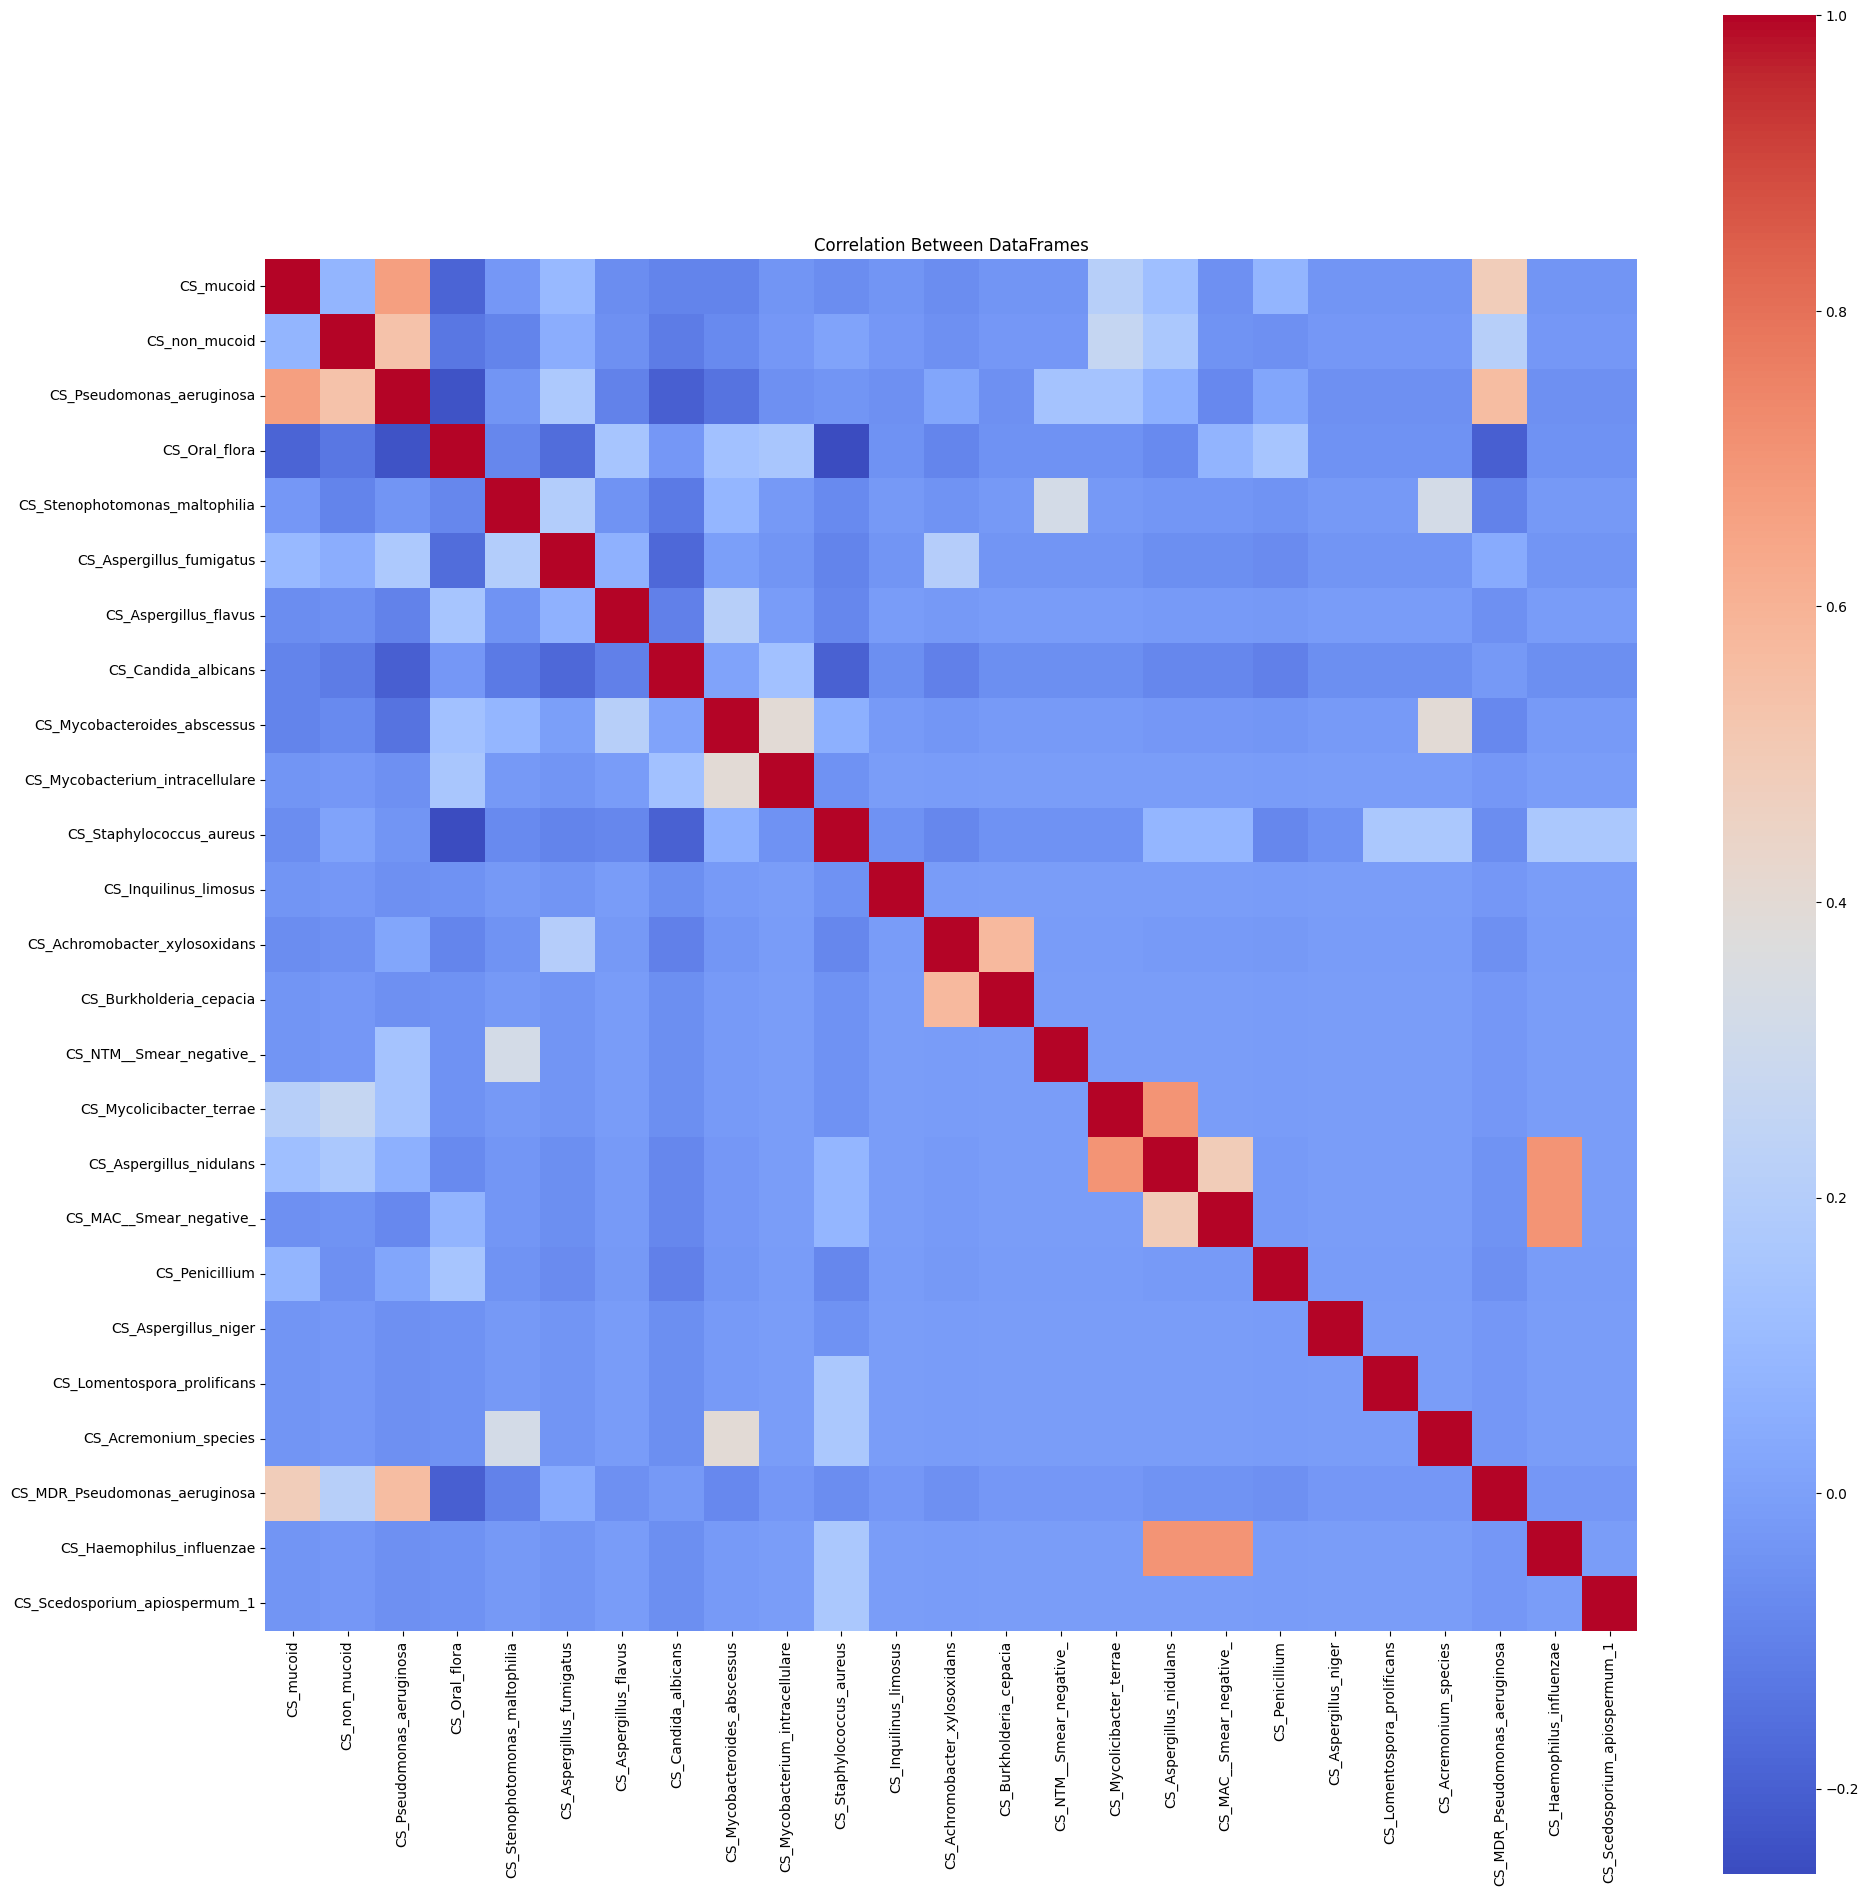

In [33]:
plt.figure(figsize=(20, 20))
sns.heatmap(data=cm,  cmap='coolwarm', square=True)
plt.title('Correlation Between DataFrames')
plt.tight_layout()
plt.show()


# Singular Matrices

We get a lot of errors with singular matrices. Here, we try and explore some using tips given by chatty.`

In [28]:
sm_form = 'IP_vs_OP ~ Aminipila + Hydroxy_fatty_acid_production_as_stress_response + two_ketoacid_oxidoreductases_disambiguation + Ferriphaselus + Robbsia + Seleniivibrio + Aquamicrobium + SecY2_SecA2_Specialized_Transport_System + Faecalicoccus + Acidisphaera + Antarcticibacterium + Flavipsychrobacter + Novosphingobium + Buchananella + Anaerospora + Hungatella + Acidibrevibacterium + Moraxella + Glutamicibacter + Pseudoroseicyclus + Petrachloros + Allorhodopirellula + Siderophore_Yersiniabactin_Biosynthesis + Methylomagnum + Amidase_clustered_with_urea_and_nitrile_hydratase_functions + Parahaliea + Resistance_to_the_fluoroquinolones_norfloxacin_and_ciprofloxacin + Methylocapsa + Testudinibacter + Tepidicaulis + Calothrix + Replication_associated_recombination_protein_RarA + Thioalkalivibrio + Aliamphritea + Queuosine_and_archaeosine + Pinibacter + Anaerobacterium + L_2_amino_4_methoxy_trans_3_butenoic_acid_synthesis + Planctomonas + Pseudodesulfovibrio + RNA_polymerase_archaeal + Possible_RNA_modification_and_stress_response_cluster + Chondrocystis + Crenothrix + Ekhidna + Flavivirga + Skermania + Catenibacillus + Ahniella + Acidomonas + Trichocoleus + Geoalkalibacter + Trueperella + Aureicoccus + ESAT_6_proteins_secretion_system_in_Mycobacteria_locus_ESX_1_ + Geofilum + Sulfuriferula + Poly_gamma_glutamate_biosynthesis + Amedibacillus + Transcriptional_regulator_AfsR + Parafilimonas + Desulfovulcanus + Daejeonella + Melghirimyces + Haloglycomyces + Barnase_barstar_complex + Gryllotalpicola + NADH_ubiquinone_oxidoreductase_vs_multi_subunit_cation_antiporter + Fodinicola + Haliea + Poriferisphaera + Heyndrickxia + Pseudofulvimonas + Gephyromycinifex + Pentose_phosphate_pathway + tRNA_splicing + Acidithrix + Confluentibacter + Alkalithermobacter + Marininema + Plasticicumulans + Paramesorhizobium + Nanchangia + Sphingobium + Chthonobacter + Sediminibacterium + Marivibrio + Numidum + Natranaerovirga + Allobaculum + Tannerella + Karelsulcia + tRNA_aminoacylation_Arg + Curtobacterium + Amantichitinum + CS_Stenophotomonas_maltophilia + CS_Staphylococcus_aureus + CS_Inquilinus_limosus + CS_Mycobacterium_intracellulare + CS_MAC__Smear_negative_ + CS_Burkholderia_cepacia + CS_Mycobacteroides_abscessus + CS_Mycolicibacter_terrae + CS_Aspergillus_nidulans + CS_Aspergillus_flavus + CS_Candida_albicans + CS_Penicillium + CS_Oral_flora + CS_Aspergillus_niger + CS_Achromobacter_xylosoxidans + CS_NTM__Smear_negative_ + CS_Haemophilus_influenzae + CS_MDR_Pseudomonas_aeruginosa + CS_Acremonium_species + CS_non_mucoid + CS_Pseudomonas_aeruginosa + CS_Aspergillus_fumigatus + CS_Lomentospora_prolificans + CS_mucoid + CS_Scedosporium_apiospermum_1'

In [43]:
smerr = sm_form.replace('+', '').replace('~', '').split()
df_combined_na[[smerr]].nunique

NameError: name 'df_combined_na' is not defined

# Early trial

Ignore the stuff down here, its probably wrong :)

In [ ]:
model = smf.mixedlm(
    'N12M_Pseudomonas_aeruginosa ~ abundance + Pseudomonas_Culture + CS_Pseudomonas_aeruginosa', 
    merged_data,
    groups=merged_data["pwCF_ID"] 
)
result = model.fit()

# Print the model summary
print(result.summary())


In [ ]:
if False:
    model = smf.mixedlm(
        'abundance ~ CS_Pseudomonas_aeruginosa + taxa_functions', 
        merged_data,
        groups=merged_data["pwCF_ID"] 
    )
    result = model.fit()

    # Print the model summary
    print(result.summary())


## Write the results

In [ ]:
coefficients = pd.DataFrame({
    "Variable": result.params.index,
    "Estimate": result.params.values,
    "Std Error": result.bse.values,
    "P-value": result.pvalues.values
})
coefficients.to_csv(os.path.join('lmm', f'{taxa}_model_coefficients.tsv'), sep="\t", index=False)

with open(os.path.join('lmm', f'{taxa}_model_results.tsv'), 'w') as f:
    f.write(result.summary().as_text())

In [ ]:
"""
# Extract fixed effect coefficients and confidence intervals
params = result.fe_params  # Fixed effect coefficients
conf_int = result.conf_int()  # Confidence intervals
conf_int.columns = ['lower', 'upper']

# Combine coefficients and confidence intervals
coefficients = pd.DataFrame({
    'coef': params,
    'lower': conf_int['lower'],
    'upper': conf_int['upper']
})

# Plot the coefficients with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(coefficients.index, coefficients['coef'], 
             yerr=(coefficients['coef'] - coefficients['lower'], coefficients['upper'] - coefficients['coef']), 
             fmt='o', capsize=5)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xticks(rotation=45)
plt.title("Fixed Effect Coefficients with Confidence Intervals")
plt.ylabel("Coefficient Value")
plt.xlabel("Predictor")
plt.tight_layout()
plt.show()
"""